In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

import nltk
import re
import pymorphy3
import kagglehub

from lib import utils

import warnings

warnings.filterwarnings("ignore")

In [3]:
dataset_dir = project_dir + '/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

In [4]:
# # Копирование данных из Kaggle в локальный каталог. Делается один раз
# import shutil

# path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
# # print("Path to dataset files:", path)

# shutil.rmtree(dataset_dir, True)
# shutil.copytree(path, dataset_dir)
# shutil.rmtree(path)

In [5]:
df_src = pd.read_csv(dataset_dir + "/IMDB Dataset.csv", delimiter=",")

df = df_src.copy()

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

Положительных и отрицательных оценок в наборе поровну, то есть распределение оценки сбалансировано.

In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

### Токенизация

Первый шаг предобработки - разбить текст на единицы, с которыми мы будем работать. 
Эти юниты называются **токенами (tokens)**, а процесс - **токенизация (tokenization)**. 
В большинстве случаев в качестве токенов используют слова, но иногда работают с буквами.

Будем работать со словами.

### Предобработка

In [9]:
# удаление тегов
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r' ', text)

# удаление ссылок
def remove_url(text):
    pattern = re.compile(r'https?://\S*')
    return pattern.sub(r'',text)

regex = re.compile(r'[A-Za-z]+')

# оставить только аглицкие слова
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

In [10]:
# загружаем список стоп-слов для аглицкого
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# ненужные хвосты, оставшиеся после предобработки текста
stop_words.append('s') 
stop_words.append('tf')

[nltk_data] Downloading package stopwords to /home/dionx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def process_data(data):
    texts = []

    # поочередно проходим по всем новостям в списке
    for text in tqdm(data):

        text = remove_html_tags(text)
        text = remove_url(text)
        text_lower = words_only(text).lower()

        texts.append(text_lower)

    return texts

In [12]:
# запускаем нашу предобработку
X = process_data(df['review'].values)

# сохраняем лэйблы
y = (df['sentiment'] == 'positive').astype(int).values

100%|██████████| 50000/50000 [00:02<00:00, 20019.80it/s]


### Нормализация

In [13]:
morph = pymorphy3.MorphAnalyzer()

def lemmatize_pymorphy(texts):
    result = []
    for text in tqdm(texts):
        words = re.findall(r"\w+", text)
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        result.append(" ".join(lemmas))
    return result

X_lemmatized = lemmatize_pymorphy(X)

100%|██████████| 50000/50000 [02:27<00:00, 338.18it/s]


### Векторизация (Tf-idf), разбиение на train и test

In [14]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2),      # Задает диапазон n-грамм (последовательностей слов). (1, 2) — униграммы и биграммы
    stop_words = stop_words,   # Список стоп-слов для исключения. 'english' или собственный список
    min_df = 0.05,             # Игнорирует термины, встречающиеся менее чем в min_df документов. 5 или 0.05 (5% от размера словаря max_features)
    max_df = 0.9,              # Игнорирует термины, встречающиеся более чем в max_df документов. 0.9 (90%)
    norm = None,               # Тип нормализации векторов. 'l2' (по умолчанию)
    # max_features = 1000,     # Ограничивает словарь наиболее частыми словами
    analyzer = 'word',         # Тип анализатора: 'word', 'char' или 'char_wb'
    use_idf = True,            # Включает/выключает использование IDF
    smooth_idf = True,         # Добавляет 1 к числителю и знаменателю IDF, чтобы избежать деления на ноль
    sublinear_tf = False,      # Применяет логарифмическое масштабирование к TF: 1 + log(tf)
)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_lemmatized, y, test_size=0.2, random_state=100, stratify=y) # type: ignore

In [16]:
# Обучаем TF-IDF на train, а затем применяем test
train_X = vectorizer.fit_transform(X_train)
test_X  = vectorizer.transform(X_test)

In [17]:
# Это список признаков (слов / n-грамм), которые TF-IDF реально оставил после обучения.
# каждая строка — токен, ставший отдельной колонкой в матрице
# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['absolutely', 'acting', 'action', 'actor', 'actors', 'actually',
       'almost', 'along', 'also', 'although'], dtype=object)

### Модель. Логистическая регрессия

LogisticRegression очень чувствительна к масштабу данных, однако в нашем случае об этом уже позаботился TfidfVectorizer.

Остается подбрать оптимальный параметр регуляризации С

In [19]:
# LogisticRegressionCV автоматически делает кросс-валидацию по параметру C
logreg_cv = LogisticRegressionCV(
    Cs = np.logspace(-5, 1, 20), # type: ignore
    cv = 5,
    penalty = 'l2',
    solver = 'liblinear',
    scoring = 'accuracy',
    max_iter = 1000,
    n_jobs = 4,
    random_state = 100
)

logreg_cv.fit(train_X, y_train)

print(f"Лучшее значение C: {logreg_cv.C_[0]:.6f}")
print(f"Accuracy на тесте: {accuracy_score(y_test, logreg_cv.predict(test_X)):.4f}")

# Готовая модель
best_model_cv = logreg_cv

Лучшее значение C: 0.001624
Accuracy на тесте: 0.8220


In [20]:
# делаем предсказание для тестовых данных
pred = best_model_cv.predict(test_X)

### Оценка качества

In [21]:
def quality(prediction_y, true_y):
    accuracy = accuracy_score(true_y, prediction_y)
    precision = precision_score(true_y, prediction_y)
    recall = recall_score(true_y, prediction_y)
    f1 = f1_score(true_y, prediction_y)
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(
        accuracy, precision, recall, f1
    ))

quality(pred, y_test)

Accuracy:  0.822
Precision: 0.805
Recall:    0.849
F1-score:  0.827


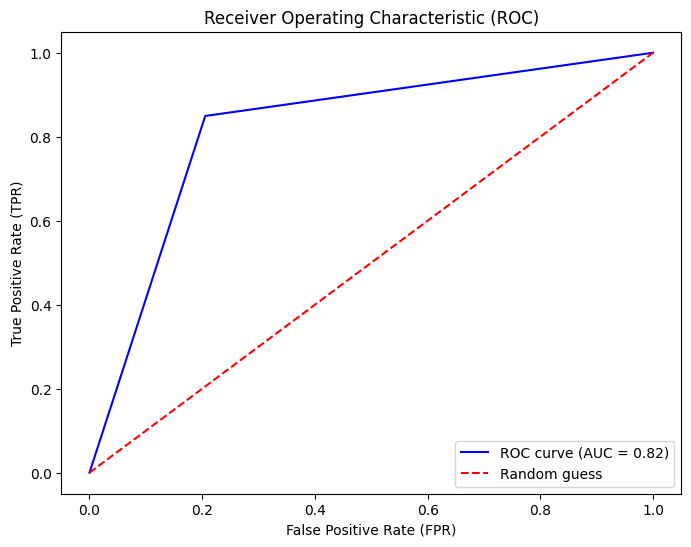

In [22]:
def roc_auc_plot(y_test, y_pred):
    # Построение ROC-кривой
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    # Вычисление AUC
    roc_auc = roc_auc_score(y_test, y_pred)

    # logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    # fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.show()

roc_auc_plot(y_test, pred)

### Визуализация коэффициентов (топ-50 слов)

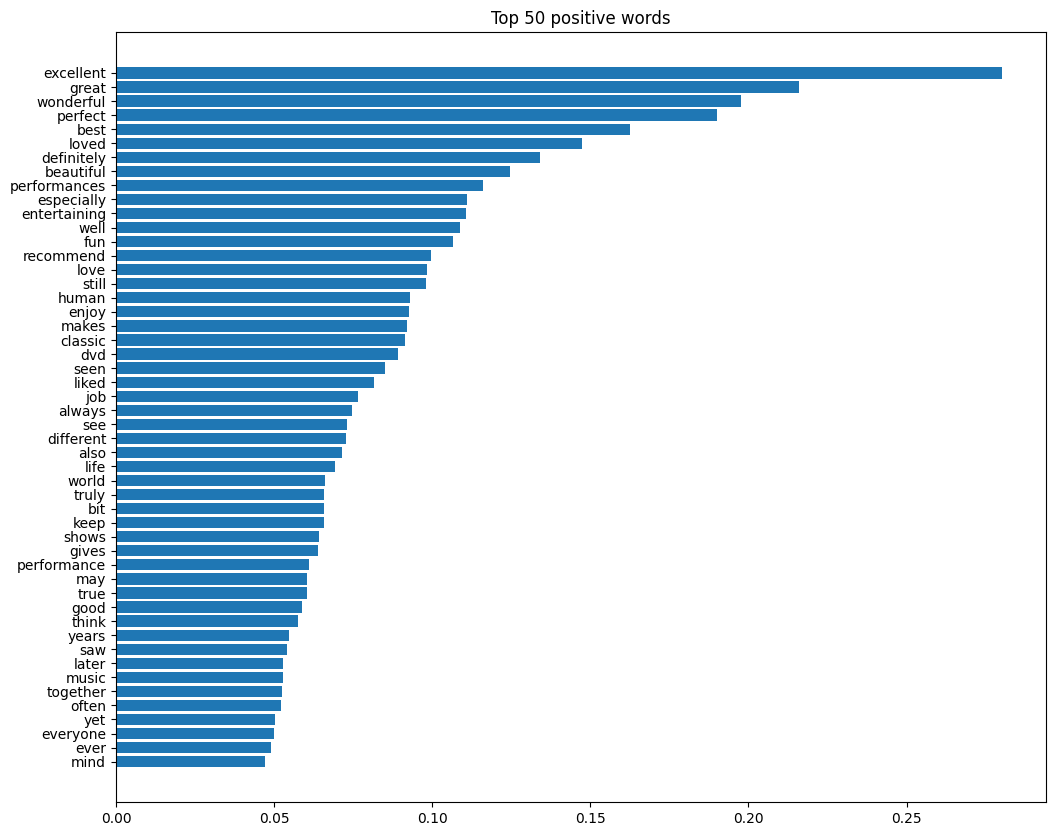

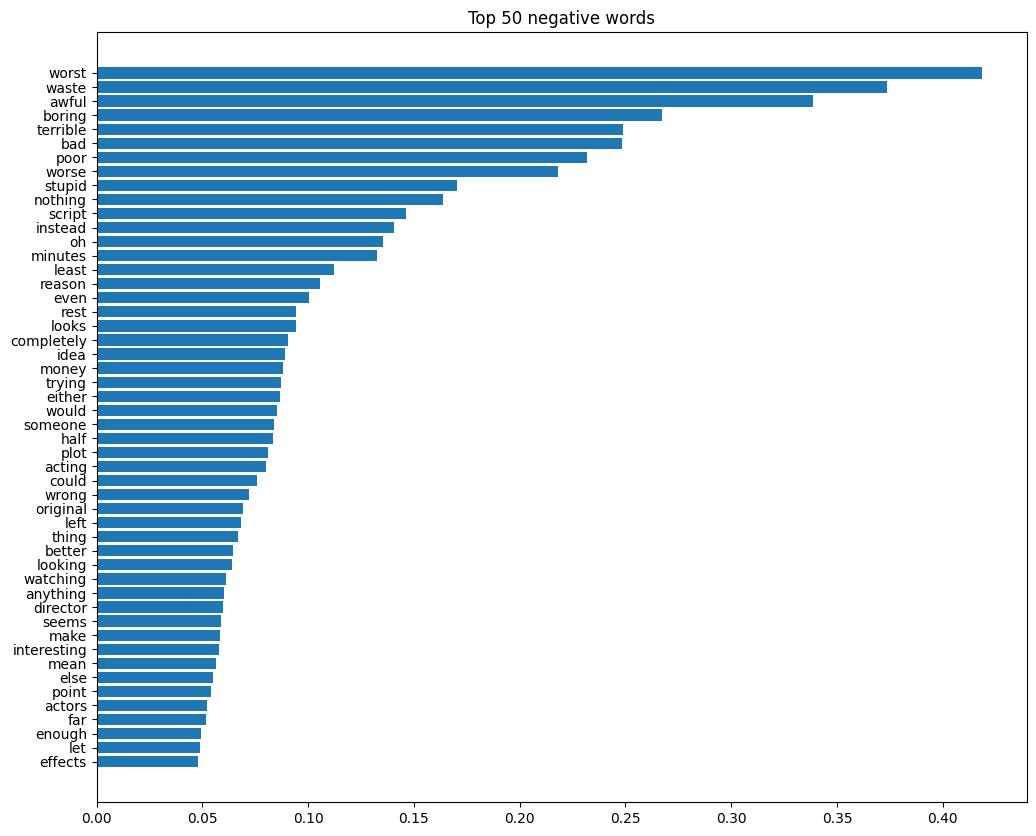

In [23]:
# Список объектов (слов), извлеченных из текста
feature_names = np.array(vectorizer.get_feature_names_out())
# coef_ значения показывают, насколько сильно каждый признак увеличивает или уменьшает вероятность принадлежности к положительному классу (классу 1)
coef = best_model_cv.coef_[0]

top_positive = np.argsort(coef)[-50:]
top_negative = np.argsort(coef)[:50][::-1]

plt.figure(figsize=(12, 10))
plt.barh(feature_names[top_positive], coef[top_positive])
plt.title("Top 50 positive words")
plt.show()

plt.figure(figsize=(12, 10))
plt.barh(feature_names[top_negative], coef[top_negative] * -1)
plt.title("Top 50 negative words")
plt.show()
